In [1]:
import glob
from pathlib import Path

In [2]:
classes_dir = glob.glob("/kaggle/input/plantvillage dataset/color/*")

len(classes_dir)

38

In [3]:
images = glob.glob('/kaggle/input/plantvillage dataset/color/**/**')
len(images)

54305

In [9]:
for class_dir in classes_dir:
    class_dir_path = Path(class_dir)
    class_name = class_dir_path.name
    class_images = glob.glob(f'{class_dir}/*')
    print(f'{class_name:<55}: {len(class_images)}')
    

Tomato___Late_blight                                   : 1909
Tomato___healthy                                       : 1591
Grape___healthy                                        : 423
Orange___Haunglongbing_(Citrus_greening)               : 5507
Soybean___healthy                                      : 5090
Squash___Powdery_mildew                                : 1835
Potato___healthy                                       : 152
Corn_(maize)___Northern_Leaf_Blight                    : 985
Tomato___Early_blight                                  : 1000
Tomato___Septoria_leaf_spot                            : 1771
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     : 513
Strawberry___Leaf_scorch                               : 1109
Peach___healthy                                        : 360
Apple___Apple_scab                                     : 630
Tomato___Tomato_Yellow_Leaf_Curl_Virus                 : 5357
Tomato___Bacterial_spot                                : 2127
Apple___Black_

In [4]:
import tensorflow as tf
import random
import cv2
import skimage

import matplotlib.pyplot as plt
import numpy as np

2024-06-27 15:34:11.101701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 15:34:11.101824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 15:34:11.267846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
class PlantVillageGenerator:
    def __init__(self, files_path, labels_to_idx, image_size, shuffle=True, color_space='rgb', split_channel=None, one_channel=None):
        self.files_path = files_path
        self.labels_to_idx = labels_to_idx
        self.image_size = image_size
        self.shuffle = shuffle
        self.color_space = color_space
        self.split_channel = split_channel
        self.one_channel = one_channel
    
    def __call__(self):
        if self.shuffle:
            random.shuffle(self.files_path)
        
        for file_path in self.files_path:
            label_str = Path(file_path).parent.name
            label_idx = self.labels_to_idx[label_str]
            label_oh = tf.one_hot(label_idx, len(self.labels_to_idx))

            image = tf.keras.preprocessing.image.load_img(file_path)
            image_arr = tf.keras.preprocessing.image.img_to_array(image)
            image_arr = tf.image.resize_with_pad(image_arr, self.image_size[0], self.image_size[1])
            image_arr /= 255.

            if self.color_space == 'lab':
                image_arr = tf.py_function(func=skimage.color.rgb2lab, inp=[image_arr], Tout=tf.float32)
                image_arr = (image_arr + [0, 128, 128]) / [100, 255, 255]
                image_arr.set_shape((*self.image_size, 3))
            elif self.color_space != 'rgb':
                raise NotImplementedError

            if self.split_channel:
                first_channel = tf.reshape(image_arr[:, :, 0], (*self.image_size, 1))
                second_channel = tf.reshape(image_arr[:, :, 1], (*self.image_size, 1))
                third_channel = tf.reshape(image_arr[:, :, 2], (*self.image_size, 1))
                
                concat = tf.concat([second_channel, third_channel], 2)

                yield (first_channel, concat), label_oh
            elif self.one_channel and self.one_channel == "AB":
                ab_channel = tf.reshape(image_arr[:, :, 1:], (*self.image_size, 2))

                yield ab_channel, label_oh
            elif self.one_channel and self.one_channel == "L":
                l_channel = tf.reshape(image_arr[:, :, 0], (*self.image_size, 1))
                yield l_channel, label_oh
            else:
                yield image_arr, label_oh

In [6]:
from collections import defaultdict
import copy
import random
from pathlib import Path

def train_validation_test_split(files_path, train_size=0.7, validation_size=0.2):
    files_path = copy.deepcopy(files_path)
    random.shuffle(files_path)
    
    files_per_class = defaultdict(list)
    for f in files_path:
        label = Path(f).parent.name
        files_per_class[label].append(f)
    
    split_files = defaultdict(list)
    for c, files in files_per_class.items():
        train_count = int(len(files) * train_size)
        validation_count = int(len(files) * validation_size)
        
        split_files['train'] += (files[:train_count])
        split_files['validation'] += (files[train_count:(train_count+validation_count)])
        split_files['test'] += (files[(train_count+validation_count):])
    
    return split_files

In [7]:
files_path = glob.glob('/kaggle/input/plantvillage dataset/color/**/**')
split_files = train_validation_test_split(files_path)
classes = set([Path(f).parent.name for f in files_path])
labels_to_idx = {c: i for i, c in enumerate(classes)}

output_signature = ((tf.TensorSpec(shape = (None, None, 1), dtype = tf.float32), tf.TensorSpec(shape = (None, None, 2), dtype = tf.float32)),
                    tf.TensorSpec(shape = (len(labels_to_idx)), dtype = tf.int16))

train = tf.data.Dataset.from_generator(
    PlantVillageGenerator(split_files['train'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)
validation = tf.data.Dataset.from_generator(
    PlantVillageGenerator(split_files['validation'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)
test = tf.data.Dataset.from_generator(
    PlantVillageGenerator(split_files['test'], labels_to_idx, (128, 128), color_space='lab', split_channel=True),
    output_signature=output_signature
)

In [8]:
img,label = next(iter(test))
print(img[0].shape)
print(img[1].shape)
print(label.shape)

(128, 128, 1)
(128, 128, 2)
(38,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test = test.shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [10]:
batched_train = train.batch(32)
batched_validation = validation.batch(32)
batched_test = test.batch(32)

In [11]:
DEFAULT_BLOCKS_ARGS = {
    "efficientnetv2-s": [
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 24,
            "output_filters": 24,
            "expand_ratio": 1,
            "se_ratio": 0.0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 4,
            "input_filters": 24,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0.0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "conv_type": 1,
            "expand_ratio": 4,
            "input_filters": 48,
            "kernel_size": 3,
            "num_repeat": 4,
            "output_filters": 64,
            "se_ratio": 0,
            "strides": 2,
        },
        {
            "conv_type": 0,
            "expand_ratio": 4,
            "input_filters": 64,
            "kernel_size": 3,
            "num_repeat": 6,
            "output_filters": 128,
            "se_ratio": 0.25,
            "strides": 2,
        },
        {
            "conv_type": 0,
            "expand_ratio": 6,
            "input_filters": 128,
            "kernel_size": 3,
            "num_repeat": 9,
            "output_filters": 160,
            "se_ratio": 0.25,
            "strides": 1,
        },
        {
            "conv_type": 0,
            "expand_ratio": 6,
            "input_filters": 160,
            "kernel_size": 3,
            "num_repeat": 15,
            "output_filters": 256,
            "se_ratio": 0.25,
            "strides": 2,
        },
    ],
    "efficientnetv2-m": [
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 24,
            "output_filters": 24,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 24,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 48,
            "output_filters": 80,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 80,
            "output_filters": 160,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 14,
            "input_filters": 160,
            "output_filters": 176,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 18,
            "input_filters": 176,
            "output_filters": 304,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 304,
            "output_filters": 512,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-l": [
        {
            "kernel_size": 3,
            "num_repeat": 4,
            "input_filters": 32,
            "output_filters": 32,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 32,
            "output_filters": 64,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 64,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 10,
            "input_filters": 96,
            "output_filters": 192,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 19,
            "input_filters": 192,
            "output_filters": 224,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 25,
            "input_filters": 224,
            "output_filters": 384,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 7,
            "input_filters": 384,
            "output_filters": 640,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b0": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b1": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b2": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
    "efficientnetv2-b3": [
        {
            "kernel_size": 3,
            "num_repeat": 1,
            "input_filters": 32,
            "output_filters": 16,
            "expand_ratio": 1,
            "se_ratio": 0,
            "strides": 1,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 16,
            "output_filters": 32,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 2,
            "input_filters": 32,
            "output_filters": 48,
            "expand_ratio": 4,
            "se_ratio": 0,
            "strides": 2,
            "conv_type": 1,
        },
        {
            "kernel_size": 3,
            "num_repeat": 3,
            "input_filters": 48,
            "output_filters": 96,
            "expand_ratio": 4,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 5,
            "input_filters": 96,
            "output_filters": 112,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 1,
            "conv_type": 0,
        },
        {
            "kernel_size": 3,
            "num_repeat": 8,
            "input_filters": 112,
            "output_filters": 192,
            "expand_ratio": 6,
            "se_ratio": 0.25,
            "strides": 2,
            "conv_type": 0,
        },
    ],
}

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 2.0,
        "mode": "fan_out",
        "distribution": "truncated_normal",
    },
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 1.0 / 3.0,
        "mode": "fan_out",
        "distribution": "uniform",
    },
}

In [12]:
import math

def round_filters(filters, width_coefficient, min_depth, depth_divisor):
    """Round number of filters based on depth multiplier."""
    filters *= width_coefficient
    minimum_depth = min_depth or depth_divisor
    new_filters = max(
        minimum_depth,
        int(filters + depth_divisor / 2) // depth_divisor * depth_divisor,
    )
    return int(new_filters)


def round_repeats(repeats, depth_coefficient):
    """Round number of repeats based on depth multiplier."""
    return int(math.ceil(depth_coefficient * repeats))

In [13]:
import copy

from keras.src import backend
from keras.src import initializers
from keras.src import layers
from keras.src.api_export import keras_export
from keras.src.models import Functional

In [14]:
def FusedMBConvBlock(
    input_filters,
    output_filters,
    expand_ratio=1,
    kernel_size=3,
    strides=1,
    se_ratio=0.0,
    bn_momentum=0.9,
    activation="swish",
    survival_probability=0.8,
    name=None,
):
    """Fuses the proj conv1x1 and depthwise_conv into a conv2d."""
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    if name is None:
        name = backend.get_uid("block0")

    def apply(inputs):
        filters = input_filters * expand_ratio
        if expand_ratio != 1:
            x = layers.Conv2D(
                filters,
                kernel_size=kernel_size,
                strides=strides,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                data_format=backend.image_data_format(),
                padding="same",
                use_bias=False,
                name=name + "expand_conv",
            )(inputs)
            x = layers.BatchNormalization(
                axis=bn_axis, momentum=bn_momentum, name=name + "expand_bn"
            )(x)
            x = layers.Activation(
                activation=activation, name=name + "expand_activation"
            )(x)
        else:
            x = inputs

        # Squeeze and excite
        if 0 < se_ratio <= 1:
            filters_se = max(1, int(input_filters * se_ratio))
            se = layers.GlobalAveragePooling2D(name=name + "se_squeeze")(x)
            if bn_axis == 1:
                se_shape = (filters, 1, 1)
            else:
                se_shape = (1, 1, filters)

            se = layers.Reshape(se_shape, name=name + "se_reshape")(se)

            se = layers.Conv2D(
                filters_se,
                1,
                padding="same",
                activation=activation,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_reduce",
            )(se)
            se = layers.Conv2D(
                filters,
                1,
                padding="same",
                activation="sigmoid",
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_expand",
            )(se)

            x = layers.multiply([x, se], name=name + "se_excite")

        # Output phase:
        x = layers.Conv2D(
            output_filters,
            kernel_size=1 if expand_ratio != 1 else kernel_size,
            strides=1 if expand_ratio != 1 else strides,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            use_bias=False,
            name=name + "project_conv",
        )(x)
        x = layers.BatchNormalization(
            axis=bn_axis, momentum=bn_momentum, name=name + "project_bn"
        )(x)
        if expand_ratio == 1:
            x = layers.Activation(
                activation=activation, name=name + "project_activation"
            )(x)

        # Residual:
        if strides == 1 and input_filters == output_filters:
            if survival_probability:
                x = layers.Dropout(
                    survival_probability,
                    noise_shape=(None, 1, 1, 1),
                    name=name + "drop",
                )(x)
            x = layers.add([x, inputs], name=name + "add")
        return x

    return apply

In [15]:
def MBConvBlock(
    input_filters,
    output_filters,
    expand_ratio=1,
    kernel_size=3,
    strides=1,
    se_ratio=0.0,
    bn_momentum=0.9,
    activation="swish",
    survival_probability=0.8,
    name=None,
):
    """MBConv block: Mobile Inverted Residual Bottleneck."""
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    if name is None:
        name = backend.get_uid("block0")

    def apply(inputs):
        # Expansion phase
        filters = input_filters * expand_ratio
        if expand_ratio != 1:
            x = layers.Conv2D(
                filters=filters,
                kernel_size=1,
                strides=1,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                padding="same",
                data_format=backend.image_data_format(),
                use_bias=False,
                name=name + "expand_conv",
            )(inputs)
            x = layers.BatchNormalization(
                axis=bn_axis,
                momentum=bn_momentum,
                name=name + "expand_bn",
            )(x)
            x = layers.Activation(activation, name=name + "expand_activation")(
                x
            )
        else:
            x = inputs

        # Depthwise conv
        x = layers.DepthwiseConv2D(
            kernel_size=kernel_size,
            strides=strides,
            depthwise_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            data_format=backend.image_data_format(),
            use_bias=False,
            name=name + "dwconv2",
        )(x)
        x = layers.BatchNormalization(
            axis=bn_axis, momentum=bn_momentum, name=name + "bn"
        )(x)
        x = layers.Activation(activation, name=name + "activation")(x)

        # Squeeze and excite
        if 0 < se_ratio <= 1:
            filters_se = max(1, int(input_filters * se_ratio))
            se = layers.GlobalAveragePooling2D(name=name + "se_squeeze")(x)
            if bn_axis == 1:
                se_shape = (filters, 1, 1)
            else:
                se_shape = (1, 1, filters)
            se = layers.Reshape(se_shape, name=name + "se_reshape")(se)

            se = layers.Conv2D(
                filters_se,
                1,
                padding="same",
                activation=activation,
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_reduce",
            )(se)
            se = layers.Conv2D(
                filters,
                1,
                padding="same",
                activation="sigmoid",
                kernel_initializer=CONV_KERNEL_INITIALIZER,
                name=name + "se_expand",
            )(se)

            x = layers.multiply([x, se], name=name + "se_excite")

        # Output phase
        x = layers.Conv2D(
            filters=output_filters,
            kernel_size=1,
            strides=1,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            data_format=backend.image_data_format(),
            use_bias=False,
            name=name + "project_conv",
        )(x)
        x = layers.BatchNormalization(
            axis=bn_axis, momentum=bn_momentum, name=name + "project_bn"
        )(x)

        if strides == 1 and input_filters == output_filters:
            if survival_probability:
                x = layers.Dropout(
                    survival_probability,
                    noise_shape=(None, 1, 1, 1),
                    name=name + "drop",
                )(x)
            x = layers.add([x, inputs], name=name + "add")

        return x

    return apply


In [26]:
def EfficientNetV2(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    min_depth=8,
    bn_momentum=0.9,
    activation="swish",
    blocks_args="default",
    model_name="efficientnetv2",
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
    branch_stem=True,
    input_shape=None,
):
    """Instantiates the EfficientNetV2 architecture using given scaling
    coefficients.

    Args:
        width_coefficient: float, scaling coefficient for network width.
        depth_coefficient: float, scaling coefficient for network depth.
        default_size: integer, default input image size.
        dropout_rate: float, dropout rate before final classifier layer.
        drop_connect_rate: float, dropout rate at skip connections.
        depth_divisor: integer, a unit of network width.
        min_depth: integer, minimum number of filters.
        bn_momentum: float. Momentum parameter for Batch Normalization layers.
        activation: activation function.
        blocks_args: list of dicts, parameters to construct block modules.
        model_name: string, model name.
        include_top: whether to include the fully-connected layer at the top of
            the network.
        weights: one of None (random initialization), "imagenet"
            (pre-training on ImageNet),
            or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`) or
            numpy array to use as image input for the model.
        input_shape: optional shape tuple, only to be specified if include_top
            is `False`. It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction when include_top
            is `False`.
            - None means that the output of the model will be the
                4D tensor output of the last convolutional layer.
            - "avg" means that global average pooling will be applied to
                the output of the last convolutional layer,
                and thus the output of the model will be a 2D tensor.
            - "max" means that global max pooling will be applied.
        classes: optional number of classes to classify images into,
            only to be specified if include_top is `True`, and if no weights
            argument is specified.
        classifier_activation: A string or callable. The activation function to
            use on the "top" layer. Ignored unless `include_top=True`. Set
            classifier_activation=None to return the logits of the "top"
            layer.
        include_preprocessing: Boolean, whether to include the preprocessing
            layer (`Rescaling`) at the bottom of the network.
            Defaults to `True`.

    Returns:
        A model instance.
    """

    if blocks_args == "default":
        blocks_args = DEFAULT_BLOCKS_ARGS[model_name]
        
    
    if branch_stem:
        l_inputs = layers.Input(shape=l_input_shape)
        ab_inputs = layers.Input(shape=ab_input_shape)

        bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

        x_l = l_inputs
        x_ab = ab_inputs

        # Build stem
        stem_filters = round_filters(
            filters=blocks_args[0]["input_filters"],
            width_coefficient=width_coefficient,
            min_depth=min_depth,
            depth_divisor=depth_divisor,
        )
        l_filters = int(stem_filters * l_ratio)
        ab_filters = stem_filters - l_filters
        # l stem
        x_l = layers.Conv2D(
            filters=l_filters,
            kernel_size=3,
            strides=2,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            use_bias=False,
            name="l_stem_conv",
        )(x_l)
        x_l = layers.BatchNormalization(
            axis=bn_axis,
            momentum=bn_momentum,
            name="l_stem_bn",
        )(x_l)
        x_l = layers.Activation(activation, name="l_stem_activation")(x_l)

        # ab stem
        x_ab = layers.Conv2D(
            filters=ab_filters,
            kernel_size=3,
            strides=2,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            use_bias=False,
            name="ab_stem_conv",
        )(x_ab)
        x_ab = layers.BatchNormalization(
            axis=bn_axis,
            momentum=bn_momentum,
            name="ab_stem_bn",
        )(x_ab)
        x_ab = layers.Activation(activation, name="ab_stem_activation")(x_ab)
    else:
        inputs = layers.Input(shape=input_shape)
        bn_axis = 3 if backend.image_data_format() == "channels_last" else 1
        
        stem_filters = round_filters(
            filters=blocks_args[0]["input_filters"],
            width_coefficient=width_coefficient,
            min_depth=min_depth,
            depth_divisor=depth_divisor,
        )
        
        x = layers.Conv2D(
            filters=stem_filters,
            kernel_size=3,
            strides=2,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            padding="same",
            use_bias=False,
            name="l_stem_conv",
        )(inputs)
        x = layers.BatchNormalization(
            axis=bn_axis,
            momentum=bn_momentum,
            name="l_stem_bn",
        )(x)
        x = layers.Activation(activation, name="l_stem_activation")(x)

    blocks_args = copy.deepcopy(blocks_args)
    b = 0
    blocks = float(sum(args["num_repeat"] for args in blocks_args))
    
    blocks_args_with_name = []
    for i, block_args in enumerate(blocks_args):
        block_args["input_filters"] = round_filters(
            filters=block_args["input_filters"],
            width_coefficient=width_coefficient,
            min_depth=min_depth,
            depth_divisor=depth_divisor,
        )
        block_args["output_filters"] = round_filters(
            filters=block_args["output_filters"],
            width_coefficient=width_coefficient,
            min_depth=min_depth,
            depth_divisor=depth_divisor,
        )
        repeats = round_repeats(
            repeats=block_args.pop("num_repeat"), depth_coefficient=depth_coefficient
        )
        
        for j in range(repeats):
            args = copy.deepcopy(block_args)
            if j > 0:
                args['strides'] = 1
                args['input_filters'] = args['output_filters']
            blocks_args_with_name.append([
                f"block{i + 1}{chr(j + 97)}_",
                args
            ])
            
    
    # build branched blocks
    for i, (name, args) in enumerate(blocks_args_with_name[:num_blocks_to_branch]):
        block = {0: MBConvBlock, 1: FusedMBConvBlock}[args.pop("conv_type")]
        
        total_input_filters = args['input_filters']
        total_output_filters = args['output_filters']
        l_input_filters = int(l_ratio * total_input_filters)
        l_output_filters = int(l_ratio * total_output_filters)
        ab_input_filters = total_input_filters - l_input_filters
        ab_output_filters = total_output_filters - l_output_filters
        
        args['input_filters'] = l_input_filters
        args['output_filters'] = l_output_filters
        x_l = block(
            activation=activation,
            bn_momentum=bn_momentum,
            survival_probability=drop_connect_rate * i / blocks,
            name=f'l_{name}',
            **args,
        )(x_l)
        
        args['input_filters'] = ab_input_filters
        args['output_filters'] = ab_output_filters
        x_ab = block(
            activation=activation,
            bn_momentum=bn_momentum,
            survival_probability=drop_connect_rate * i / blocks,
            name=f'ab_{name}',
            **args,
        )(x_ab)
        
    # concat
    if branch_stem:
        x = layers.Concatenate()([x_l, x_ab])
        
    # build remaining serial block
    for i, (name, args) in enumerate(blocks_args_with_name[num_blocks_to_branch:], start=num_blocks_to_branch):
        block = {0: MBConvBlock, 1: FusedMBConvBlock}[args.pop("conv_type")]
        
        x = block(
            activation=activation,
            bn_momentum=bn_momentum,
            survival_probability=drop_connect_rate * i / blocks,
            name=name,
            **args,
        )(x)
           
              
    # Build top
    top_filters = round_filters(
        filters=1280,
        width_coefficient=width_coefficient,
        min_depth=min_depth,
        depth_divisor=depth_divisor,
    )
    x = layers.Conv2D(
        filters=top_filters,
        kernel_size=1,
        strides=1,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        padding="same",
        data_format=backend.image_data_format(),
        use_bias=False,
        name="top_conv",
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis,
        momentum=bn_momentum,
        name="top_bn",
    )(x)
    x = layers.Activation(activation=activation, name="top_activation")(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name="top_dropout")(x)
        x = layers.Dense(
            classes,
            activation=classifier_activation,
            kernel_initializer=DENSE_KERNEL_INITIALIZER,
            bias_initializer=initializers.Constant(0.0),
            name="predictions",
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

            
    # Create model.
    if branch_stem:
        model = Functional([l_inputs, ab_inputs], x, name=model_name)
    else:
        model = Functional(inputs, x, name=model_name)
        
    return model

In [27]:
def EfficientNetV2B0(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.0,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    branch_stem=True,
    input_shape=None
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=224,
        model_name="efficientnetv2-b0",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        branch_stem=branch_stem,
        input_shape=input_shape
    )


def EfficientNetV2B1(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.1,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=240,
        model_name="efficientnetv2-b1",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2B2(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.1,
    depth_coefficient=1.5,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=260,
        model_name="efficientnetv2-b2",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2B3(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.2,
    depth_coefficient=1.4,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=300,
        model_name="efficientnetv2-b3",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2S(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.0,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=384,
        model_name="efficientnetv2-s",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2M(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.0,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        default_size=480,
        model_name="efficientnetv2-m",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )


def EfficientNetV2L(
    include_top=True,
    l_input_shape=None,
    ab_input_shape=None,
    l_ratio=0.5,
    num_blocks_to_branch=3,
    width_coefficient=1.0,
    depth_coefficient=1.0,
    dropout_rate=0.5,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
):
    return EfficientNetV2(
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        dropout_rate=dropout_rate,
        default_size=480,
        model_name="efficientnetv2-l",
        include_top=include_top,
        l_input_shape=l_input_shape,
        ab_input_shape=ab_input_shape,
        l_ratio=l_ratio,
        num_blocks_to_branch=num_blocks_to_branch,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
    )

# 100% L

In [35]:
files_path = glob.glob('/kaggle/input/plantvillage dataset/color/**/**')
split_files = train_validation_test_split(files_path)
classes = set([Path(f).parent.name for f in files_path])
labels_to_idx = {c: i for i, c in enumerate(classes)}

output_signature = (tf.TensorSpec(shape = (None, None, 1), dtype = tf.float32),
tf.TensorSpec(shape = (len(labels_to_idx)), dtype = tf.int16))

train = tf.data.Dataset.from_generator(
PlantVillageGenerator(split_files['train'], labels_to_idx, (128, 128), color_space='lab', split_channel=False, one_channel="L"),
output_signature=output_signature
)
validation = tf.data.Dataset.from_generator(
PlantVillageGenerator(split_files['validation'], labels_to_idx, (128, 128), color_space='lab', split_channel=False, one_channel="L"),
output_signature=output_signature
)
test = tf.data.Dataset.from_generator(
PlantVillageGenerator(split_files['test'], labels_to_idx, (128, 128), color_space='lab', split_channel=False, one_channel="L"),
output_signature=output_signature
)
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test = test.shuffle(1000).prefetch(buffer_size = AUTOTUNE)

batched_train = train.batch(32)
batched_validation = validation.batch(32)
batched_test = test.batch(32)

In [36]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.5,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=0,
    classes=38,
    branch_stem=False,
    input_shape=(128, 128, 1)
)

model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)
model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_conv         │ (None, 64, 64,    │        144 │ input_layer_6[0]… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_bn           │ (None, 64, 64,    │         64 │ l_stem_conv[0][0] │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_activation   │ (None, 64, 64,    │          0 │ l_stem_bn[0][0]   │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64, 8) │      1,152 │ l_stem_activatio… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64, 8) │         32 │ block1a_project_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64, 8) │          0 │ block1a_project_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        128 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │        512 │ block2a_expand_a… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │         64 │ block2a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_conv │ (None, 16, 16,    │      9,216 │ block2a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_bn   │ (None, 16, 16,    │        256 │ block3a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_act… │ (None, 16, 16,    │          0 │ block3a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_project_co… │ (None, 16, 16,    │      1,536 │ block3a_expand_a… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_project_bn  │ (None, 16, 16,    │         96 │ block3a_project_

 Total params: 803,462 (3.06 MB)

 Trainable params: 787,318 (3.00 MB)

 Non-trainable params: 16,144 (63.06 KB)

In [37]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2scustom_0block_5050/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [38]:
## history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      1/Unknown 91s 91s/step - accuracy: 0.0625 - loss: 3.9326

I0000 00:00:1719502902.050091     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1188/Unknown 948s 722ms/step - accuracy: 0.3099 - loss: 2.6441

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.65536, saving model to /kaggle/working/two_branch_efficientnetv2scustom_0block_100L/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 1191s 927ms/step - accuracy: 0.3100 - loss: 2.6436 - val_accuracy: 0.6554 - val_loss: 1.1544
Epoch 2/25
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6549 - loss: 1.1419
Epoch 2: val_accuracy did not improve from 0.65536
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.6549 - loss: 1.1417 - val_accuracy: 0.5683 - val_loss: 1.5330
Epoch 3/25
1185/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7391 - loss: 0.8405
Epoch 3: val_accuracy improved from 0.65536 to 0.78081, saving model to /kaggle/working/two_branch_efficientnetv2scustom_0block_100L/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.7391 - loss: 0.8404 - val_accuracy: 0.7808 - val_loss: 0.7109
Epoch 4/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7798 - loss: 0.6973
Epoch 4: val_accuracy im

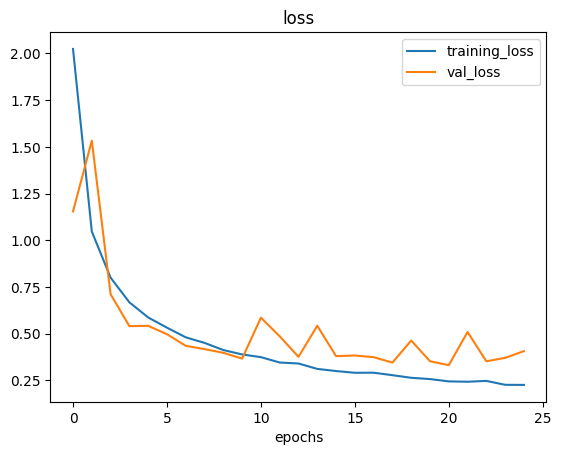

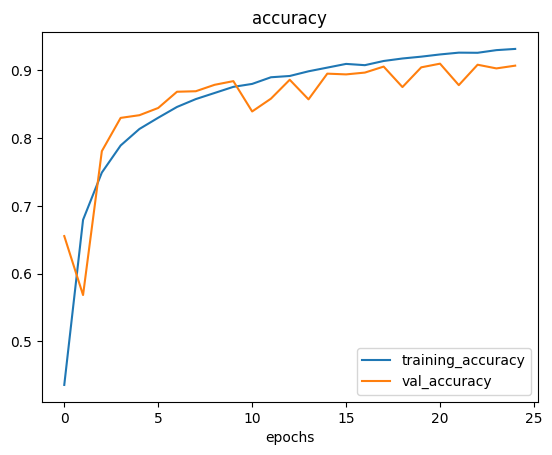

In [41]:
plot_loss_curves(history)

In [42]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2scustom_0block_100L/cp-0021.keras')
saved.evaluate(batched_test, verbose=2)

171/171 - 126s - 736ms/step - accuracy: 0.9128 - loss: 0.3201


[0.3200606405735016, 0.9128045439720154]

# 100% AB

In [43]:
files_path = glob.glob('/kaggle/input/plantvillage dataset/color/**/**')
split_files = train_validation_test_split(files_path)
classes = set([Path(f).parent.name for f in files_path])
labels_to_idx = {c: i for i, c in enumerate(classes)}

output_signature = (tf.TensorSpec(shape = (None, None, 2), dtype = tf.float32),
tf.TensorSpec(shape = (len(labels_to_idx)), dtype = tf.int16))

train = tf.data.Dataset.from_generator(
PlantVillageGenerator(split_files['train'], labels_to_idx, (128, 128), color_space='lab', split_channel=False, one_channel="AB"),
output_signature=output_signature
)
validation = tf.data.Dataset.from_generator(
PlantVillageGenerator(split_files['validation'], labels_to_idx, (128, 128), color_space='lab', split_channel=False, one_channel="AB"),
output_signature=output_signature
)
test = tf.data.Dataset.from_generator(
PlantVillageGenerator(split_files['test'], labels_to_idx, (128, 128), color_space='lab', split_channel=False, one_channel="AB"),
output_signature=output_signature
)
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test = test.shuffle(1000).prefetch(buffer_size = AUTOTUNE)

batched_train = train.batch(32)
batched_validation = validation.batch(32)
batched_test = test.batch(32)

In [44]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.5,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=0,
    classes=38,
    branch_stem=False,
    input_shape=(128, 128, 2)
)

model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)
model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_conv         │ (None, 64, 64,    │        288 │ input_layer_7[0]… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_bn           │ (None, 64, 64,    │         64 │ l_stem_conv[0][0] │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_activation   │ (None, 64, 64,    │          0 │ l_stem_bn[0][0]   │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64, 8) │      1,152 │ l_stem_activatio… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64, 8) │         32 │ block1a_project_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64, 8) │          0 │ block1a_project_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        128 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │        512 │ block2a_expand_a… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │         64 │ block2a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_conv │ (None, 16, 16,    │      9,216 │ block2a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_bn   │ (None, 16, 16,    │        256 │ block3a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_expand_act… │ (None, 16, 16,    │          0 │ block3a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_project_co… │ (None, 16, 16,    │      1,536 │ block3a_expand_a… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3a_project_bn  │ (None, 16, 16,    │         96 │ block3a_project_

 Total params: 803,606 (3.07 MB)

 Trainable params: 787,462 (3.00 MB)

 Non-trainable params: 16,144 (63.06 KB)

In [46]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2scustom_0block_100AB/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [47]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
   1188/Unknown 682s 509ms/step - accuracy: 0.3957 - loss: 2.2108
Epoch 1: val_accuracy improved from -inf to 0.58015, saving model to /kaggle/working/two_branch_efficientnetv2scustom_0block_100AB/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 861s 660ms/step - accuracy: 0.3958 - loss: 2.2102 - val_accuracy: 0.5801 - val_loss: 1.4816
Epoch 2/25
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7221 - loss: 0.8940
Epoch 2: val_accuracy improved from 0.58015 to 0.62061, saving model to /kaggle/working/two_branch_efficientnetv2scustom_0block_100AB/cp-0002.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.7221 - loss: 0.8939 - val_accuracy: 0.6206 - val_loss: 1.2575
Epoch 3/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7967 - loss: 0.6533
Epoch 3: val_accuracy improved from 0.62061 to 0.77685, saving model to /kaggle/working/two_branch_efficientnetv2scustom_0block_100AB/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.7

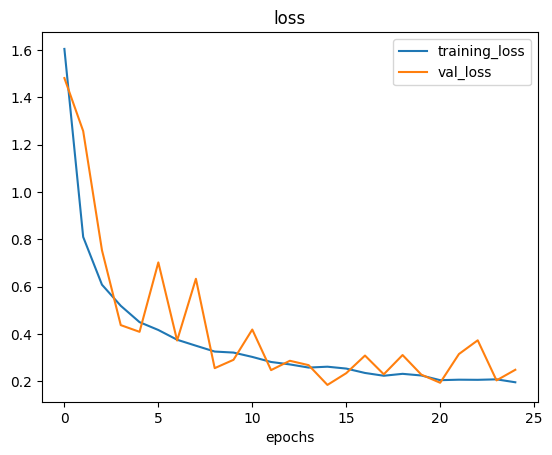

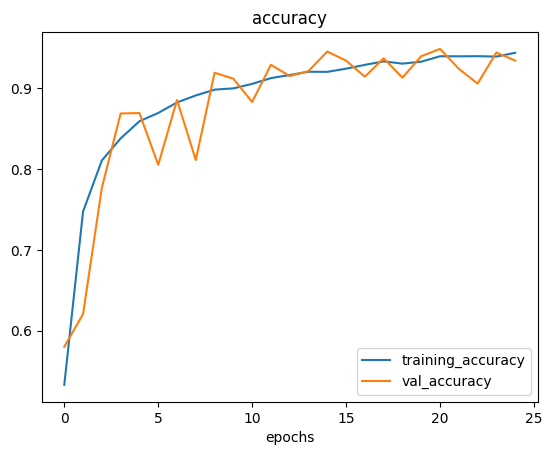

In [48]:
plot_loss_curves(history)

In [49]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2scustom_0block_100AB/cp-0021.keras')
saved.evaluate(batched_test, verbose=2)

171/171 - 86s - 506ms/step - accuracy: 0.9535 - loss: 0.1654


[0.16536842286586761, 0.953471302986145]

# L ratio 50%

In [19]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.5,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=0,
    classes=38
)
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [20]:
model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_conv         │ (None, 64, 64, 8) │         72 │ input_layer[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_conv        │ (None, 64, 64, 8) │        144 │ input_layer_1[0]… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_bn           │ (None, 64, 64, 8) │         32 │ l_stem_conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_bn          │ (None, 64, 64, 8) │         32 │ ab_stem_conv[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_activation   │ (None, 64, 64, 8) │          0 │ l_stem_bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_activation  │ (None, 64, 64, 8) │          0 │ ab_stem_bn[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ l_stem_activatio… │
│ (Concatenate)       │ 16)               │            │ ab_stem_activati… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64, 8) │      1,152 │ concatenate[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64, 8) │         32 │ block1a_project_… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64, 8) │          0 │ block1a_project_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        128 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │        512 │ block2a_expand_a… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │         64 │ block2a_project_

 Total params: 803,534 (3.07 MB)

 Trainable params: 787,390 (3.00 MB)

 Non-trainable params: 16,144 (63.06 KB)

In [21]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2scustom_0block_5050/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [22]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      1/Unknown 76s 76s/step - accuracy: 0.0312 - loss: 4.0913

I0000 00:00:1718986435.678303      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718986435.746840      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 652s 485ms/step - accuracy: 0.4152 - loss: 2.1849

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1718987029.774060      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.63600, saving model to /kaggle/working/two_branch_efficientnetv2scustom_0block_5050/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 816s 623ms/step - accuracy: 0.4153 - loss: 2.1844 - val_accuracy: 0.6360 - val_loss: 1.2788
Epoch 2/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7491 - loss: 0.8092
Epoch 2: val_accuracy improved from 0.63600 to 0.78201, saving model to /kaggle/working/two_branch_efficientnetv2scustom_0block_5050/cp-0002.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.7491 - loss: 0.8090 - val_accuracy: 0.7820 - val_loss: 0.6842
Epoch 3/25
1185/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8162 - loss: 0.5972
Epoch 3: val_accuracy improved from 0.78201 to 0.84081, saving model to /kaggle/working/two_branch_efficientnetv2scustom_0block_5050/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.8162 - loss: 0.5971 - val_accuracy: 0.8408 - val_loss: 0.4918
Epoch 4/25
1186/11

In [40]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs


    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

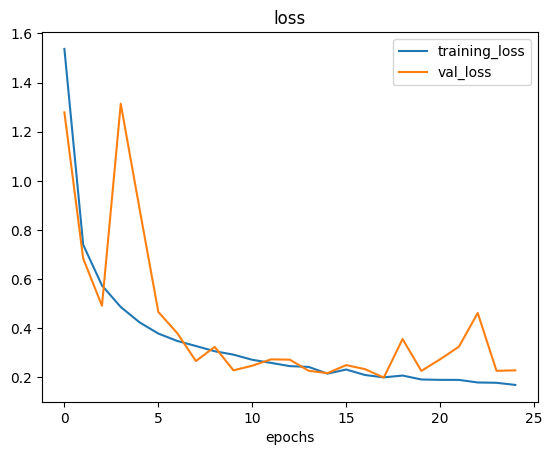

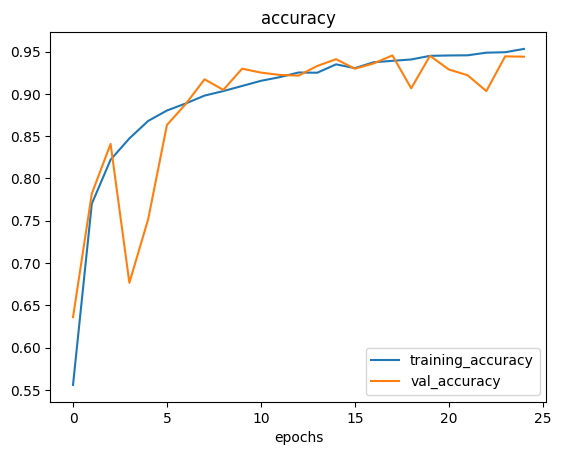

In [24]:
plot_loss_curves(history)

In [25]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2scustom_0block_5050/cp-0018.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1718987820.951353      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 88s - 516ms/step - accuracy: 0.9450 - loss: 0.1996


[0.1995537281036377, 0.9450448751449585]

## L Ratio 20%

In [26]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.2,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=0,
    classes=38
)
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [27]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2scustom_0block_2080/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [28]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      5/Unknown 52s 30ms/step - accuracy: 0.0516 - loss: 4.4398  

W0000 00:00:1718987965.915959      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 104s 43ms/step - accuracy: 0.4111 - loss: 2.2102

W0000 00:00:1718988021.451811      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.43230, saving model to /kaggle/working/two_branch_efficientnetv2scustom_0block_2080/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 113s 51ms/step - accuracy: 0.4113 - loss: 2.2096 - val_accuracy: 0.4323 - val_loss: 2.2758
Epoch 2/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7443 - loss: 0.8263
Epoch 2: val_accuracy improved from 0.43230 to 0.79113, saving model to /kaggle/working/two_branch_efficientnetv2scustom_0block_2080/cp-0002.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.7443 - loss: 0.8263 - val_accuracy: 0.7911 - val_loss: 0.6669
Epoch 3/25
1185/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8050 - loss: 0.6188
Epoch 3: val_accuracy did not improve from 0.79113
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.8051 - loss: 0.6187 - val_accuracy: 0.2698 - val_loss: 4.6751
Epoch 4/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8342 - loss: 0.5266
Epoch 4: val_accuracy impr

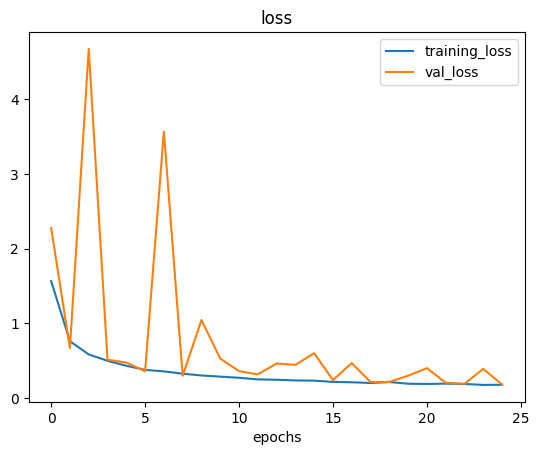

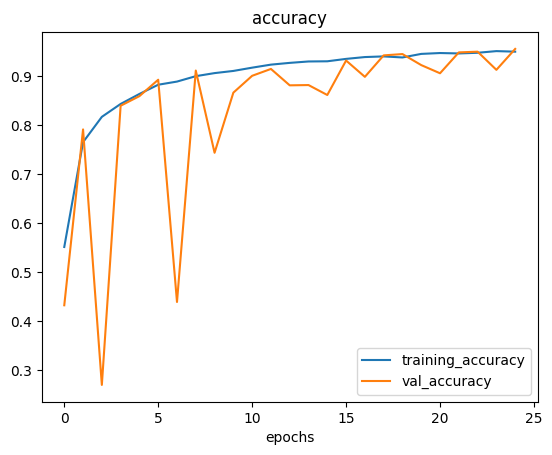

In [29]:
plot_loss_curves(history)

In [30]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2scustom_0block_2080/cp-0025.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1718988650.529737      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 59s - 345ms/step - accuracy: 0.9577 - loss: 0.1537


[0.15368416905403137, 0.9576845765113831]

# ONE BRANCH

In [24]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.2,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=1,
    classes=38
)
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [25]:
model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_conv         │ (None, 64, 64, 3) │         27 │ input_layer[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_conv        │ (None, 64, 64,    │        234 │ input_layer_1[0]… │
│ (Conv2D)            │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_bn           │ (None, 64, 64, 3) │         12 │ l_stem_conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_bn          │ (None, 64, 64,    │         52 │ ab_stem_conv[0][… │
│ (BatchNormalizatio… │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_stem_activation   │ (None, 64, 64, 3) │          0 │ l_stem_bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_stem_activation  │ (None, 64, 64,    │          0 │ ab_stem_bn[0][0]  │
│ (Activation)        │ 13)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 1) │         27 │ l_stem_activatio… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 7) │        819 │ ab_stem_activati… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 1) │          4 │ l_block1a_projec… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 7) │         28 │ ab_block1a_proje… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_block1a_project_… │ (None, 64, 64, 1) │          0 │ l_block1a_projec… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ab_block1a_project… │ (None, 64, 64, 7) │          0 │ ab_block1a_proje… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64, 8) │          0 │ l_block1a_projec… │
│ (Concatenate)       │                   │            │ ab_block1a_proje… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      2,304 │ concatenate[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        128 │ block2a_expand_c

 Total params: 803,273 (3.06 MB)

 Trainable params: 787,129 (3.00 MB)

 Non-trainable params: 16,144 (63.06 KB)

In [26]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2scustom_1block_2080/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [27]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      1/Unknown 78s 78s/step - accuracy: 0.0312 - loss: 4.1961

I0000 00:00:1718991371.373482      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718991371.443037      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 647s 480ms/step - accuracy: 0.3952 - loss: 2.2805

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1718991959.611774      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.67250, saving model to /kaggle/working/two_branch_efficientnetv2scustom_1block_2080/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 809s 616ms/step - accuracy: 0.3953 - loss: 2.2800 - val_accuracy: 0.6725 - val_loss: 1.0960
Epoch 2/25
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7347 - loss: 0.8665
Epoch 2: val_accuracy improved from 0.67250 to 0.77104, saving model to /kaggle/working/two_branch_efficientnetv2scustom_1block_2080/cp-0002.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - accuracy: 0.7348 - loss: 0.8664 - val_accuracy: 0.7710 - val_loss: 0.7597
Epoch 3/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8108 - loss: 0.6103
Epoch 3: val_accuracy improved from 0.77104 to 0.85870, saving model to /kaggle/working/two_branch_efficientnetv2scustom_1block_2080/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.8108 - loss: 0.6103 - val_accuracy: 0.8587 - val_loss: 0.4474
Epoch 4/25
1187/11

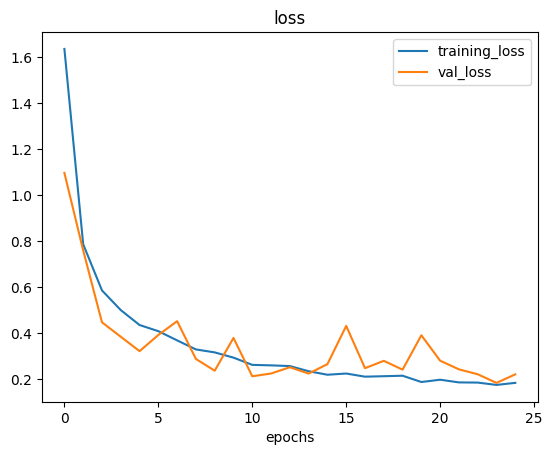

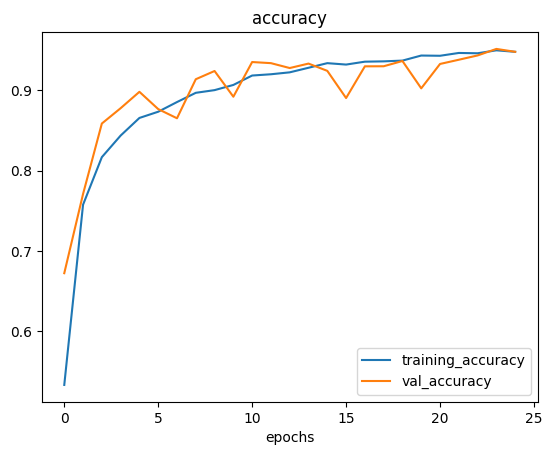

In [30]:
plot_loss_curves(history)

In [31]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2scustom_1block_2080/cp-0024.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1718992853.107511      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 94s - 550ms/step - accuracy: 0.9564 - loss: 0.1609


[0.16094310581684113, 0.9564022421836853]

# TWO BRANCH

In [34]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.2,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=2,
    classes=38
)
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [35]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2scustom_2block_2080/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [36]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      5/Unknown 59s 30ms/step - accuracy: 0.0602 - loss: 3.9556  

W0000 00:00:1718992996.987858      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 115s 47ms/step - accuracy: 0.4329 - loss: 2.1222

W0000 00:00:1718993056.926652      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.60651, saving model to /kaggle/working/two_branch_efficientnetv2scustom_2block_2080/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 125s 56ms/step - accuracy: 0.4331 - loss: 2.1217 - val_accuracy: 0.6065 - val_loss: 1.7976
Epoch 2/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7580 - loss: 0.7862
Epoch 2: val_accuracy improved from 0.60651 to 0.80551, saving model to /kaggle/working/two_branch_efficientnetv2scustom_2block_2080/cp-0002.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.7581 - loss: 0.7860 - val_accuracy: 0.8055 - val_loss: 0.6375
Epoch 3/25
1186/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8230 - loss: 0.5666
Epoch 3: val_accuracy improved from 0.80551 to 0.83989, saving model to /kaggle/working/two_branch_efficientnetv2scustom_2block_2080/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.8230 - loss: 0.5665 - val_accuracy: 0.8399 - val_loss: 0.5337
Epoch 4/25
1186/118

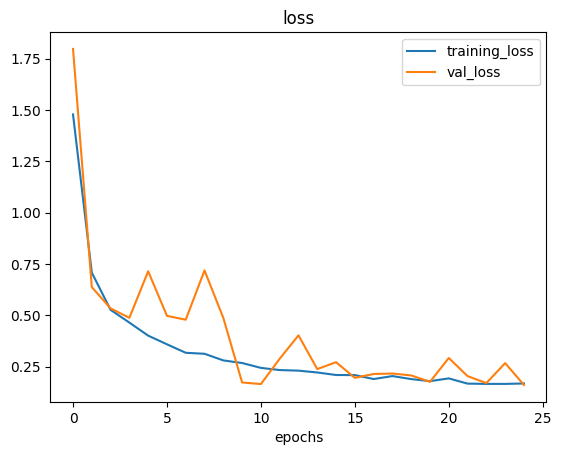

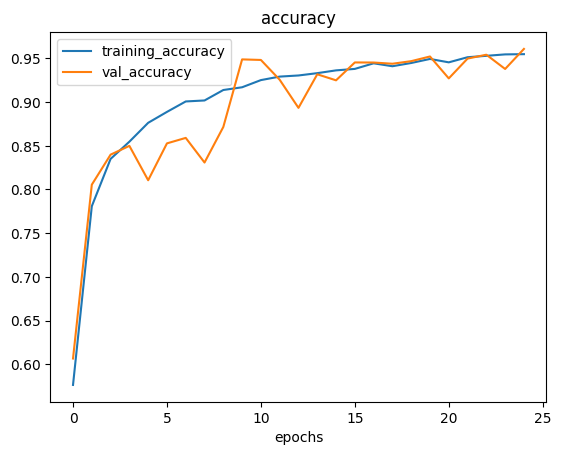

In [37]:
plot_loss_curves(history)

In [38]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2scustom_2block_2080/cp-0025.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1718993749.636797      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 67s - 391ms/step - accuracy: 0.9617 - loss: 0.1551


[0.15513204038143158, 0.9617146253585815]

# THREE BRANCH

In [39]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.2,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=3,
    classes=38
)
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [40]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2scustom_3block_2080/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [41]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      5/Unknown 64s 32ms/step - accuracy: 0.0690 - loss: 4.3351

W0000 00:00:1718993878.117945      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 124s 51ms/step - accuracy: 0.4246 - loss: 2.1523

W0000 00:00:1718993942.963180      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.67158, saving model to /kaggle/working/two_branch_efficientnetv2scustom_3block_2080/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 135s 60ms/step - accuracy: 0.4248 - loss: 2.1517 - val_accuracy: 0.6716 - val_loss: 1.1030
Epoch 2/25
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7652 - loss: 0.7542
Epoch 2: val_accuracy did not improve from 0.67158
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.7652 - loss: 0.7541 - val_accuracy: 0.4141 - val_loss: 3.0925
Epoch 3/25
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8206 - loss: 0.5745
Epoch 3: val_accuracy improved from 0.67158 to 0.85446, saving model to /kaggle/working/two_branch_efficientnetv2scustom_3block_2080/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8206 - loss: 0.5745 - val_accuracy: 0.8545 - val_loss: 0.4783
Epoch 4/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8547 - loss: 0.4743
Epoch 4: val_accuracy impr

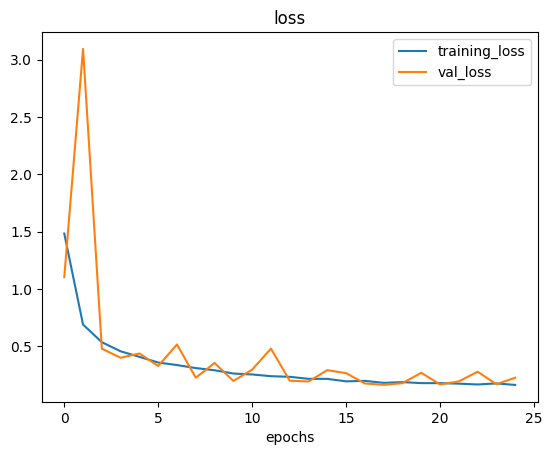

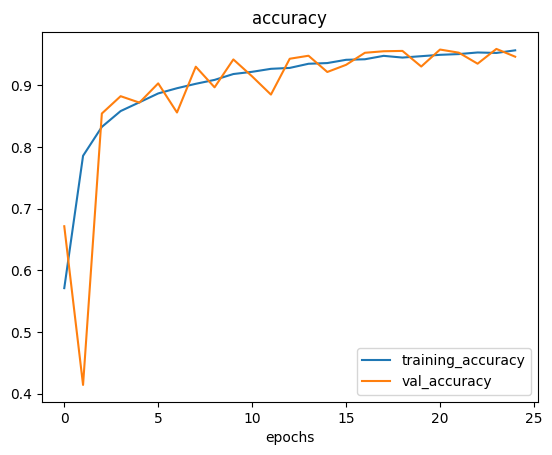

In [42]:
plot_loss_curves(history)

In [43]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2scustom_3block_2080/cp-0024.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1718994668.824351      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 63s - 371ms/step - accuracy: 0.9661 - loss: 0.1333


[0.13329753279685974, 0.9661110043525696]

# FOUR BRANCH

In [44]:
model = EfficientNetV2B0(
    l_input_shape=(128, 128, 1),
    ab_input_shape=(128, 128, 2),
    l_ratio=0.2,
    depth_coefficient=0.5,
    width_coefficient=0.5,
    num_blocks_to_branch=4,
    classes=38
)
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        metrics=['accuracy']
)

In [45]:
checkpoint_path = "/kaggle/working/two_branch_efficientnetv2scustom_4block_2080/cp-{epoch:04d}.keras"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='max',
                                                         verbose=1)

In [46]:
history = model.fit(
    batched_train,
    validation_data=batched_validation,
    verbose=1,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
      5/Unknown 69s 32ms/step - accuracy: 0.0356 - loss: 4.5048  

W0000 00:00:1718994814.561796      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


   1188/Unknown 134s 55ms/step - accuracy: 0.4622 - loss: 2.0282

W0000 00:00:1718994884.320395      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.71730, saving model to /kaggle/working/two_branch_efficientnetv2scustom_4block_2080/cp-0001.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 146s 65ms/step - accuracy: 0.4624 - loss: 2.0276 - val_accuracy: 0.7173 - val_loss: 0.9722
Epoch 2/25
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7902 - loss: 0.6759
Epoch 2: val_accuracy improved from 0.71730 to 0.74753, saving model to /kaggle/working/two_branch_efficientnetv2scustom_4block_2080/cp-0002.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.7902 - loss: 0.6757 - val_accuracy: 0.7475 - val_loss: 0.9551
Epoch 3/25
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8487 - loss: 0.4836
Epoch 3: val_accuracy improved from 0.74753 to 0.76256, saving model to /kaggle/working/two_branch_efficientnetv2scustom_4block_2080/cp-0003.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.8487 - loss: 0.4836 - val_accuracy: 0.7626 - val_loss: 0.8501
Epoch 4/25
1187/118

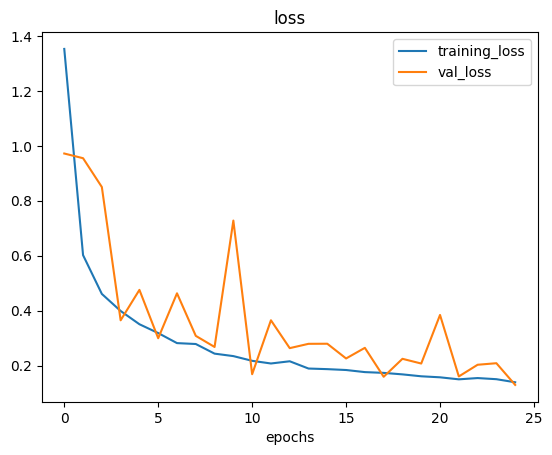

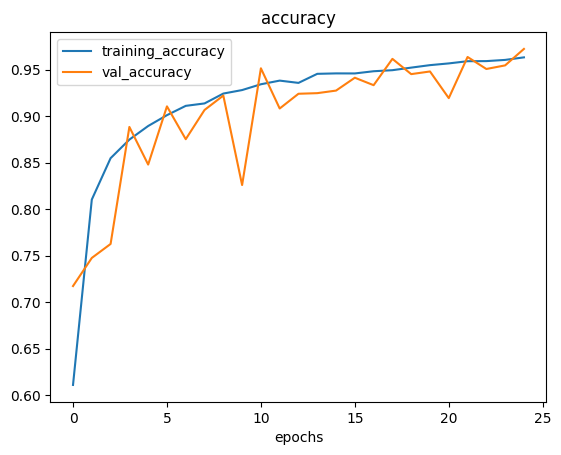

In [47]:
plot_loss_curves(history)

In [48]:
saved = tf.keras.models.load_model('/kaggle/working/two_branch_efficientnetv2scustom_4block_2080/cp-0025.keras')
saved.evaluate(batched_test, verbose=2)

W0000 00:00:1718995630.368389      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


171/171 - 67s - 391ms/step - accuracy: 0.9736 - loss: 0.1159


[0.1159353256225586, 0.9736215472221375]